In [1]:
# import required packages
# source: https://www.kaggle.com/allunia/patterns-of-colorectal-cancer-wally

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='darkgrid')

# Import classifiers used:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier

# Data Transformation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer


# Import ovo and ovr related stuff
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import VotingClassifier

# Pre-processing Data:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV, KFold

# Import Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_score, recall_score

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kerastuner as kt
from tensorflow import keras

#Base Libraries
import random

from tqdm import tqdm_notebook
import pickle

In [2]:
# Ensure that GPU is detected
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Read Data from CSV File & Do Preprocessing required

In [3]:
df = pd.read_csv('../01_Data_Files/hmnist_64_64_L.csv', engine='c') # read 64x64 gray scale images as csv
dict_class_names = {1: 'Tumor', 2:'Stroma', 3:'Complex', 4:'Lymphoma', 5:'Debris', 6:'Mucosa', 7:'Adipose', 8:'Empty'}

# Adds a column with name of the label based on the integer value
df['label_name'] = df['label'].map(dict_class_names)

class_names = ['Tumor', 'Stroma', 'Complex', 'Lymphoma', 'Debris', 'Mucosa', 'Adipose', 'Empty']

In [4]:
X = df.drop(['label', 'label_name'], axis=1).values
y = df.loc[:, 'label_name'].values.reshape(-1,1)

assert len(X) == len(y), 'X & y length mismatch'

### Use MinMax Scaler to scale the values of X from 0-255 to between 0 and 1. 

The min max scaler uses the following formula to calculate the scaled values:

$$ x^{\prime} = \frac{x-min(x)}{max(x)-min(x)}$$

In [5]:
# Scale Values of X via a MinMaxScaler
# We know that our input can vary between 0 and 255
min_max_scaler = MinMaxScaler()

# Create a fake array with values between 0 and 255 to use for fitting min max scaler
scaling_array = np.append(
    [np.zeros_like(X[0], dtype=np.int16)], [np.full_like(X[0], 255, dtype=np.int16)], axis=0
)
min_max_scaler.fit(scaling_array)
X_scaled = min_max_scaler.transform(X)

X_scaled_tf_shape = X_scaled.reshape(-1,64,64,1)

### One Hot Encode Y values for Tensorflow Usage & Label Encode for Sklearn Usage

To learn more about one hot encoding:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=one%20hot%20encode#sklearn.preprocessing.OneHotEncoder

To learn more about label encoding:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html?highlight=encoder#sklearn.preprocessing.LabelEncoder




In [6]:
# One Hot Encode y_values:
one_hot_encoder = OneHotEncoder(sparse=False)
y_one_hot = one_hot_encoder.fit_transform(y)
print('One Hot Encoded Y Shape: ', y_one_hot.shape)

# Label Encoding to conver String labels to integer labels:
label_encoder = LabelEncoder()
y_int_encode = label_encoder.fit_transform(y)
print(f'Label Encoded Y Shape: {y_int_encode.shape}, Max Value: {y_int_encode.max()}, Min Value: {y_int_encode.min()}')

One Hot Encoded Y Shape:  (5000, 8)
Label Encoded Y Shape: (5000,), Max Value: 7, Min Value: 0


In [ ]:
# Lets make sure that that distribution of our data hasn't changed significantly due to scaling. 
# Mostly a sanity check
fig, axs = plt.subplots(4, 4, figsize=(12,16))
for i in range(4):

    # Show Original Images
    original_image = np.reshape(X_scaled[i], (64,64))
    axs[0,i].imshow(original_image, cmap='gray')
    label_image = y[i]
    axs[0,i].set_title(f'Original Image: {label_image}')
    axs[0,i].grid(False)

    # Show histogram of values in image:
    sns.distplot(original_image, ax=axs[1,i])
    axs[1,i].set_title('Original Image Distribution')
    axs[1,i].set_ylabel('')

    # Show Scaled Images:
    scaled_image = np.reshape(X_scaled[i], (64,64))
    axs[2,i].imshow(scaled_image, cmap='gray')
    label_image = y[i]
    axs[2,i].set_title(f'MinMax Scaled Image: {label_image}')
    axs[2,i].grid(False)

    # Show histogram of values in image:
    sns.distplot(scaled_image, ax=axs[3,i])
    axs[3,i].set_title('MinMax Image Distribution')
    axs[3,i].set_ylabel('')

plt.tight_layout()
plt.savefig('Image_Scaled_Distributions.png')


### Setup Nested CV

Nested CV allows us to do both hyper parameter tuning and classifier performance comparision without producing an overly-optimistic score as in the case of non-nested CV. This happens when information leaks into the model since we use the same data to not only do hyper paramter tuning but also evaluation. 

We will use evolutionary algorithms to find the best parameters instead of relying on grid search. This is done in the interest of time. 

##### Parameters for each model:

Create a parameter grid for evolutionary search: 
The structure of the grid wil be: {clf_name:{param_name:value, param_name:value}, clf_name:{param_name:value...}}

Nested dictionaries!

In [ ]:
# Convolutional Neural Network:
# Architecture: Input - Conv2D, Conv 2D, Conv2D, Flatten, Dense, Dense, Dense - Output
# Source: https://www.kaggle.com/efeergun96/colorectal-histology-prediction-by-cnn
def create_model(hp):
    model = Sequential()

    model.add(Conv2D(
        input_shape = (64,64,1),
        filters = 128, 
        kernel_size = (5,5), 
        padding = 'same',
        activation = 'relu' 
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(8, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-3, 1e-4, 1e-6])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate= hp_learning_rate) , loss = "categorical_crossentropy", metrics=["categorical_accuracy", 'accuracy'])
    return model

In [ ]:
param_grid = {}
param_grid['k_neighbors_clf'] = {'n_neighbors':np.linspace(3, 20, num=3,dtype=np.int),
                                'weights':['distance'],
                                'leaf_size': np.linspace(10, 30, num=3, dtype=np.int),
                                'p':[1]}

param_grid['gaussianb_clf'] = {'var_smoothing':[1e-9, 1e-6, 1e-3]}
param_grid['svm_clf_ovr']  = {  'C'     : np.logspace(-5, 3, num=4, base=10),
                            'gamma' : np.logspace(-9, 3, num=4, base=10), 
                            'kernel': ['rbf'],
                            'random_state':[42],
                            'decision_function_shape':['ovr']}

param_grid['random_forest_clf'] = {
    'n_estimators':[20,100,200],
    'random_state':[42]
}

param_grid['dummy_clf'] = {'strategy': ['stratified'],
                            'random_state':[42]}

random.seed(42)

In [ ]:
k_neighbors_clf = KNeighborsClassifier()
gaussianb_clf = GaussianNB()

svm_clf_ovr = svm.SVC()

from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier()

# Used for a baseline. 
dummy_clf = DummyClassifier()

tuner = kt.Hyperband(create_model, 
                                    objective= 'val_accuracy',
                                    max_epochs=30,
                                    hyperband_iterations=2,
                                    directory = 'keras-model-logs',
                                    project_name = 'ece740-project1'
                                    )

# Dictionary of all classifiers
clfs = {
    'tuner':tuner,
    'k_neighbors_clf' : k_neighbors_clf,
    'gaussianb_clf' : gaussianb_clf,
    'svm_clf_ovr' : svm_clf_ovr,
    'random_forest_clf' : random_forest_clf,
    'dummy_clf': dummy_clf 
}

scoring = {
    'acc':'accuracy',
    'prec_macro':'precision_macro',
    'rec_macro':'recall_macro',
    'f1_macro':'f1_macro',
}

def custom_scorer(y_true, y_pred, score_dict):
    if not score_dict:
        score_dict['test_acc'] = []
        score_dict['test_prec_macro'] = []
        score_dict['test_rec_macro'] = []
        score_dict['test_f1_macro'] = []
    
    score_dict['test_acc'].append(accuracy_score(y_true, y_pred))
    score_dict['test_prec_macro'].append(precision_score(y_true, y_pred, average='macro'))
    score_dict['test_rec_macro'].append(recall_score(y_true, y_pred, average='macro'))
    score_dict['test_f1_macro'].append(f1_score(y_true, y_pred, average='macro'))



In [ ]:
# Dictionary will contain scores for each of the 
RANDOM_SEED = 42

nested_scores = {}
non_nested_scores = {}
# Using F1-macro since we have a balanced data set. 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

for key, value in clfs.items():
    print(f'Fitting and testing {key} classifier')
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

    # Formats the label (y) as either integer encoding or one-hot encoding for non-cnn clfs 
    # and cnn-clfs accordingly. 
    if key == 'tuner':
        y_current = y_one_hot
        n_jobs_param = 1

        nested_scores[key] = {}

        for train_idx, test_idx in tqdm_notebook(outer_cv.split(X_scaled_tf_shape, y_int_encode)):
            # create fake training target with integer encode to be used for inner split. 
            # SKFold does not like one-hot-encoded labels. 
            fake_train_target_ = y_int_encode[train_idx]
            
            train_data, test_data = X_scaled_tf_shape[train_idx], X_scaled_tf_shape[test_idx]
            train_target, test_target = y_current[train_idx], y_current[test_idx]

            # Do parameter tuning with validation/inner cv. 

            for i, (train_idx_inner, val_idx) in tqdm_notebook(enumerate(inner_cv.split(train_data, fake_train_target_))):
                train_data_inner, validate_data = train_data[train_idx_inner], train_data[val_idx]
                train_target_inner, validate_target = train_target[train_idx_inner], train_target[val_idx]

                value.search(train_data_inner, train_target_inner, epochs=20, validation_data = (validate_data, validate_target), callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])


            best_hps = value.get_best_hyperparameters(num_trials = 1)[0]
            best_model = value.get_best_models(1)[0]

            history = best_model.fit(train_data, train_target, epochs=20, verbose=1)

            predictions = best_model.predict(test_data)

            predictions = one_hot_encoder.inverse_transform(predictions)
            test_target_oh = one_hot_encoder.inverse_transform(test_target)

            # Do testing & append scores
            custom_scorer(test_target_oh, predictions, nested_scores[key])

        print(f'Testing complete for {key}, results:')
        print(nested_scores[key])
    
    
    else:
        y_current = y_int_encode
        n_jobs_param = -1

        clf = GridSearchCV(estimator=value, 
                        param_grid=param_grid[key], 
                        scoring='f1_macro',
                        cv=inner_cv, 
                        n_jobs=n_jobs_param,
                        verbose=2,
                        refit=True)

        clf.fit(X_scaled, y_current)

        print(f'Parameter Optimization Complete for {key}, best params: \n{clf.best_params_}')
        nested_scores[key] = cross_validate(
            clf,
            X=X_scaled,
            y=y_current,
            scoring=scoring,
            cv=outer_cv,
            n_jobs=n_jobs_param,
            verbose=2,
        )

        print(f'Testing complete for {key}, results:')
        print(nested_scores[key])

### Save & Analyze Data Generated from Nested Cross-Validation

In [ ]:
# Save & Load Raw Scores DF
if input('What would you like to do?: \n1. Save Raw Scores\n2. Load Previously Saved Raw Scores\nIf you are not sure, select 2') == 1:
    with open('nested_scores.pickle', 'wb') as handle:
        pickle.dump(nested_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    try:
        with open('nested_scores.pickle', 'rb') as handle:
            nested_scores = pickle.load(handle)
        print('Score File Loaded!')
    except:
        print('Score File Not Found. Please check the file')

In [ ]:
# Process Scores
acc_list = []
prec_list = []
recall_list = []
f1_list = []
classifier_list = []
for key,value in nested_scores.items():
    classifier_list.append(key)
    classifier_list.append(key)
    classifier_list.append(key)
    classifier_list.append(key)
    classifier_list.append(key)

    acc_list.extend(value['test_acc'])
    prec_list.extend(value['test_prec_macro'])
    recall_list.extend(value['test_rec_macro'])
    f1_list.extend(value['test_f1_macro'])

df_scores = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Classifier'])
df_scores['Accuracy'] = acc_list
df_scores['Precision'] = prec_list
df_scores['Recall'] = recall_list
df_scores['F1'] = f1_list
df_scores['Classifier'] = classifier_list

df_scores_grouped = df_scores.groupby('Classifier')
df_scores_aggregate = df_scores_grouped.agg([np.mean, np.std])
df_score_mean = df_scores_grouped.mean()
df_score_std = df_scores_grouped.std()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
df_score_mean.plot.bar(yerr=df_score_std, ax=ax, rot=0, capsize=4, ylim=(0,1))
plt.title('Classifier Performance Comparision')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Classifier-Score-Bar-Plot.png')

In [ ]:
# Paired T-Test for Dependent Samples
# https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce

from scipy import stats

ttest, pval = stats.ttest_rel(df_scores_grouped.get_group('tuner')['F1'], df_scores_grouped.get_group('svm_clf_ovr')['F1'])
print(f'P-Value: {pval}')
print(f'T-Test Value: {ttest}')

if pval < 0.05:
    print('Reject Null Hypothesis: Ensemble of Binary Classifiers (SVM) has the same or lower F1 Score as the best performing non-ensemble classifier.')
else:
    print('Accept Null Hypothesis')


In [ ]:
cnn_final = clfs['tuner'].get_best_models(num_models=1)[0]
random_forest_final = RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
X_scaled_train, X_scaled_test, y_one_hot_train, y_one_hot_test = train_test_split(X_scaled_tf_shape, y_one_hot, random_state = 42, test_size=0.2)

history = cnn_final.fit(X_scaled_train, y_one_hot_train, epochs=20, validation_data=(X_scaled_test, y_one_hot_test), verbose=2, shuffle=True)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

In [ ]:
y_pred_cnn = cnn_final.predict(X_scaled)
y_pred_cnn = one_hot_encoder.inverse_transform(y_pred_cnn)
y_test_cnn = one_hot_encoder.inverse_transform(y_one_hot)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test_cnn, y_pred_cnn), annot=True, fmt='d', ax=ax, xticklabels=class_names, yticklabels=class_names, square=True)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True, left=True, labelleft=True)
plt.yticks(va='center')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Convolutional Neural Network Performance on All Data')
plt.savefig('cnn_test_confusion_matrix')

In [ ]:
y_pred_rfc = cross_val_predict(random_forest_final, X_scaled, y_int_encode, cv=5, n_jobs=-1)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(confusion_matrix(y_int_encode, y_pred_rfc), annot=True, fmt='d', ax=ax, xticklabels=class_names, yticklabels=class_names, square=True)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True, left=True, labelleft=True)
plt.yticks(va='center')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Random Forest Performance on Cross-Validated Data')
plt.savefig('rfc_test_confusion_matrix_cross_validated.png')

### Implement a Data Generator To Improve CNN Efficiency & Compare Performance with Non-Augmented Version

In [7]:
def base_model_cnn():
    model = Sequential()

    model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = (64,64,1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256,activation = "relu"))          
    model.add(Dense(64,activation = "relu"))
    model.add(Dense(32,activation = "relu"))
    model.add(Dense(8, activation = "softmax"))
    model.compile(optimizer = "Adam", learning_rate=1e-4, loss = "categorical_crossentropy", metrics=["accuracy"])

    return model

In [24]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

f1_score_dict = {}
accuracy_score_dict = {}

f1_score_dict['base'] = []
f1_score_dict['augmented'] = []
accuracy_score_dict['base'] = []
accuracy_score_dict['augmented'] = []

for train_idx, test_idx in tqdm_notebook(cv.split(X_scaled_tf_shape, y_one_hot)):
    # create fake training target with integer encode to be used for splitting
    # SKFold does not like one-hot-encoded labels. 
    train_data, test_data = X_scaled_tf_shape[train_idx], X_scaled_tf_shape[test_idx]
    train_target, test_target = y_one_hot[train_idx], y_one_hot[test_idx]

    # Create validation set to avoid overfitting before testing
    train_data, validation_data, train_target, validation_target = train_test_split(train_data, train_target, random_state = 42, test_size=0.1)

    base_model = base_model_cnn()
    augmented_model = base_model_cnn()

    print('Fitting Image Generator')

    datagenerator = ImageDataGenerator(
        rotation_range=0.3,
        zoom_range=0.3,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True
    )

    datagenerator.fit(train_data)

    base_model.fit(train_data, train_target, epochs=30, validation_data=(validation_data, validation_target), verbose=2, shuffle=True)

    augmented_model.fit(datagenerator.flow(train_data, train_target, batch_size=32), epochs=30, validation_data=(validation_data, validation_target), steps_per_epoch=100)

    predictions_base = base_model.predict(test_data)
    predictions_augmented = augmented_model.predict(test_data)

    predictions_base = one_hot_encoder.inverse_transform(predictions_base)
    predictions_augmented = one_hot_encoder.inverse_transform(predictions_augmented)
    test_target = one_hot_encoder.inverse_transform(test_target)

    f1_score_dict['base'].append(f1_score(test_target, predictions_base, average='macro'))
    f1_score_dict['augmented'].append(f1_score(test_target, predictions_augmented, average='macro'))

    accuracy_score_dict['base'].append(accuracy_score(test_target, predictions_base))
    accuracy_score_dict['augmented'].append(accuracy_score(test_target, predictions_augmented))

.4688 - accuracy: 0.8142 - val_loss: 0.6624 - val_accuracy: 0.7350
Epoch 22/30
113/113 - 1s - loss: 0.4693 - accuracy: 0.8183 - val_loss: 0.8292 - val_accuracy: 0.6550
Epoch 23/30
113/113 - 1s - loss: 0.3818 - accuracy: 0.8575 - val_loss: 0.7307 - val_accuracy: 0.7300
Epoch 24/30
113/113 - 1s - loss: 0.3386 - accuracy: 0.8711 - val_loss: 0.6184 - val_accuracy: 0.7675
Epoch 25/30
113/113 - 1s - loss: 0.3379 - accuracy: 0.8731 - val_loss: 0.9749 - val_accuracy: 0.6775
Epoch 26/30
113/113 - 1s - loss: 0.3432 - accuracy: 0.8733 - val_loss: 0.7449 - val_accuracy: 0.7175
Epoch 27/30
113/113 - 1s - loss: 0.2616 - accuracy: 0.9022 - val_loss: 0.7783 - val_accuracy: 0.7300
Epoch 28/30
113/113 - 1s - loss: 0.3047 - accuracy: 0.8828 - val_loss: 0.7435 - val_accuracy: 0.7650
Epoch 29/30
113/113 - 1s - loss: 0.2324 - accuracy: 0.9153 - val_loss: 0.7398 - val_accuracy: 0.7450
Epoch 30/30
113/113 - 1s - loss: 0.2182 - accuracy: 0.9186 - val_loss: 0.6765 - val_accuracy: 0.7750
Epoch 1/30
100/100 [====

In [25]:
accuracy_df = pd.DataFrame(accuracy_score_dict)
f1_df = pd.DataFrame(f1_score_dict)

In [26]:
accuracy_df

,base,augmented
0,0.779,0.714
1,0.740,0.736
2,0.750,0.716
3,0.763,0.751
4,0.783,0.715


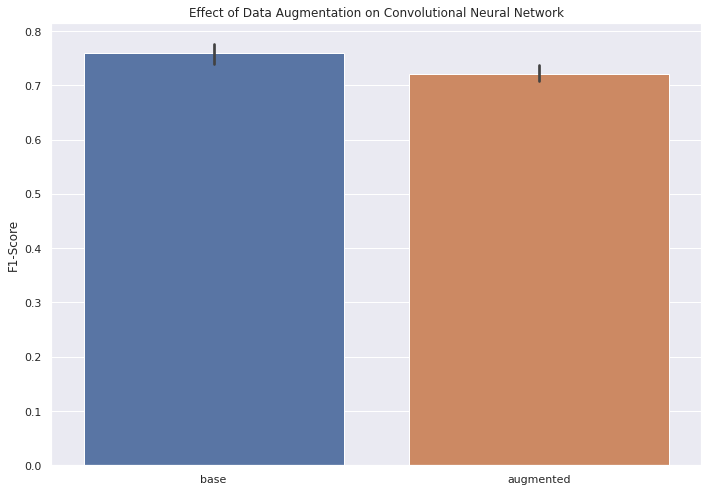

In [30]:
fig, axs = plt.subplots(figsize=(10,7))
sns.barplot(data=f1_df, ax=axs, )
plt.title('Effect of Data Augmentation on Convolutional Neural Network')
plt.ylabel('F1-Score')
plt.tight_layout()
plt.savefig('Augmented-performance.png')

In [ ]:
cnn_image_file = '../04_Figures/cnn_architecture.png'
tf.keras.utils.plot_model(model, to_file=cnn_image_file, show_shapes=True)

In [ ]:
X_scaled_train, X_scaled_test, y_one_hot_train, y_one_hot_test = train_test_split(X_scaled_tf_shape, y_one_hot, random_state = 42, test_size=0.2)

In [ ]:
model.fit_generator(datagenerator.flow(X_scaled_train, y_one_hot_train, batch_size=32), epochs=20, validation_data= (X_scaled_test, y_one_hot_test), steps_per_epoch=100)

### Try XCeption and Resnet to compare performance. 

In [ ]:
from kerastuner.applications import HyperResNet
hypermodel = HyperResNet(input_shape=(64,64,1), classes=8)
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    directory='hyper-model-res-net',
    project_name='col-res-net',
    max_epochs=20
)

tuner.search(X_scaled_train, y_one_hot_train, epochs=20, validation_data=(X_scaled_test, y_one_hot_test))

In [ ]:
from kerastuner import HyperParameters
from kerastuner.applications import HyperXception
from kerastuner.tuners import Hyperband
hypermodel = HyperXception(input_shape=(64,64,1), classes=8)
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    directory='hyper-model-xception',
    project_name='col-xception',
    max_epochs=20
)

tuner.search(X_scaled_train, y_one_hot_train, epochs=20, validation_data=(X_scaled_test, y_one_hot_test))